In [1]:
import os
import geopandas as gpd
import pandas as pd
from osgeo import gdal
import boto3
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray

## read the farm boundaries
Create a buffer and save to another file

show it in a plot

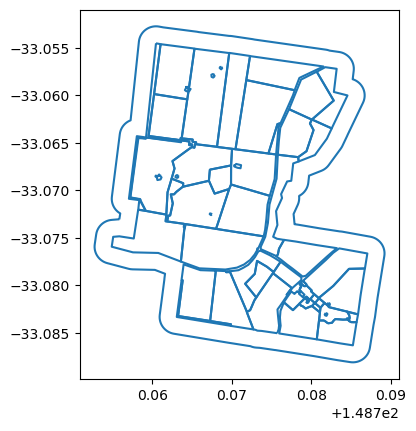

In [2]:
farm = gpd.read_file('C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-2023-05-02_07-35-04 (1).json')
farm_buffer = gpd.GeoDataFrame(geometry=farm.dissolve().to_crs('epsg:3577').buffer(200)).to_crs(farm.crs)
fig, ax = plt.subplots()
farm_buffer.boundary.plot(ax=ax)
farm.boundary.plot(ax=ax)
plt.show()

In [3]:
farm_buffer.to_file('C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer.geojson')

## set up the boto3 to access data in S3 directly
I have masked the values for `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY`. You will have to use your own

In [4]:
os.environ["AWS_ACCESS_KEY_ID"] = "XXXXXXXXXXXXXXXXXXXXXX"
os.environ["AWS_SECRET_ACCESS_KEY"] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

# Setup where you want the data from
BUCKET = "cibo-agriwebb"
BUCKET_PATH = 'tiles'

# Connect to the bucket
s3 = boto3.resource('s3')

# Generate a list of files in the Bucket
fileList = ['/vsis3/' + BUCKET + '/'+key.key for key in (s3.Bucket(BUCKET).objects.filter(Prefix=BUCKET_PATH))
                 if key.key.endswith('.tif')] 
fileList

ClientError: An error occurred (InvalidAccessKeyId) when calling the ListObjects operation: The AWS Access Key Id you provided does not exist in our records.

crop the images to the farm and save locally

this takes time, be patient

In [5]:
fname_vector = 'C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer.geojson'

input_fname = [
    '/vsis3/cibo-agriwebb/tiles/agriwebb_tsdm.tif',
    '/vsis3/cibo-agriwebb/tiles/agriwebb_fc1.tif',
    '/vsis3/cibo-agriwebb/tiles/agriwebb_fc2.tif',
    '/vsis3/cibo-agriwebb/tiles/agriwebb_fc3.tif'
]

output_fname =  [
    'C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_tsdm.tif',
    'C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_fc1.tif',
    'C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_fc2.tif',
    'C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_fc3.tif'
]
 
for i in np.arange(len(input_fname)):
    if not os.path.exists(output_fname[i]):
        print('working on ', output_fname[i])
        OutTile = gdal.Warp('temp.tif',
                            input_fname[i],
                            cutlineDSName=fname_vector,
                            cropToCutline=True,
                            creationOptions  = "COMPRESS=LZW",
                            dstNodata = 0,
                            #dstSRS = 'EPSG:3577'
                            )
        OutTile = None 
        
        translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-co COMPRESS=LZW"))
        OutTile = gdal.Translate(output_fname[i], 'temp.tif', options=translateoptions)
        OutTile = None
    else:
        print(output_fname[i], ' exists, skip')
        

C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_tsdm.tif  exists, skip
C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_fc1.tif  exists, skip
C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_fc2.tif  exists, skip
C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/old_redbank_mob-buffer_fc3.tif  exists, skip


## now read all these files and put it in an xarray

read the dates from the txt file

In [6]:
with open('C:/Users/Juan/OneDrive - Cibo Labs Pty Ltd/Foragecaster/layer_dates.txt') as file:
    dates = [line.rstrip() for line in file]

len(dates)

810

In [7]:
tsdm = rioxarray.open_rasterio(output_fname[0]).to_dataset(name='tsdm')
tsdm = tsdm.rename({'band': 'time'})
tsdm['time'] = pd.to_datetime(dates)
 
fc1 = rioxarray.open_rasterio(output_fname[1]).to_dataset(name='bare')
fc1 = fc1.rename({'band': 'time'})
fc1['time'] = pd.to_datetime(dates)
fc2 = rioxarray.open_rasterio(output_fname[2]).to_dataset(name='green')
fc2 = fc2.rename({'band': 'time'})
fc2['time'] = pd.to_datetime(dates)
fc3 = rioxarray.open_rasterio(output_fname[3]).to_dataset(name='non-green')
fc3 = fc3.rename({'band': 'time'})
fc3['time'] = pd.to_datetime(dates)

put it all together in a DataSet.

Set zeroes to Nans and convert the values for fc from 0 to 100  (they are 100-200)

In [8]:
data = xr.merge([tsdm,fc1,fc2,fc3]) 
data = data.where(data != 0)
data['bare'] -= 100
data['green'] -= 100
data['non-green'] -= 100
data

<xarray.Dataset>
Dimensions:      (time: 810, y: 396, x: 339)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05 2017-01-15 ... 2023-08-30
  * x            (x) float64 6.636e+05 6.636e+05 6.636e+05 ... 6.67e+05 6.67e+05
  * y            (y) float64 6.341e+06 6.341e+06 ... 6.338e+06 6.338e+06
    spatial_ref  int32 0
Data variables:
    tsdm         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    bare         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    non-green    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

there are lots of dates with no data for the farm. Drop them

In [9]:
data = data.dropna(dim='time', how='all')
data

<xarray.Dataset>
Dimensions:      (time: 438, y: 396, x: 339)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-18 2017-01-28 ... 2023-08-30
  * x            (x) float64 6.636e+05 6.636e+05 6.636e+05 ... 6.67e+05 6.67e+05
  * y            (y) float64 6.341e+06 6.341e+06 ... 6.338e+06 6.338e+06
    spatial_ref  int32 0
Data variables:
    tsdm         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    bare         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    non-green    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

pick a pixel and show the values

In [10]:
x,y=(100, 100)
this_pix=data.isel(x=x, y=y).to_dataframe() 
this_pix

tsdm  bare  green  non-green         x          y  spatial_ref
time                                                                        
2017-01-18  2029.0   9.0    7.0       84.0  664615.0  6340485.0            0
2017-01-28  1632.0   7.0   12.0       80.0  664615.0  6340485.0            0
2017-02-17     NaN   NaN    NaN        NaN  664615.0  6340485.0            0
2017-03-09   856.0  20.0    5.0       76.0  664615.0  6340485.0            0
2017-03-29  1812.0  15.0   78.0        8.0  664615.0  6340485.0            0
...            ...   ...    ...        ...       ...        ...          ...
2023-08-02     NaN   NaN    NaN        NaN  664615.0  6340485.0            0
2023-08-10     NaN   NaN    NaN        NaN  664615.0  6340485.0            0
2023-08-15  5789.0   5.0   59.0       36.0  664615.0  6340485.0            0
2023-08-25  2304.0  14.0   61.0       25.0  664615.0  6340485.0            0
2023-08-30     NaN   NaN    NaN        NaN  664615.0  6340485.0            0

[438 rows x 7 columns]

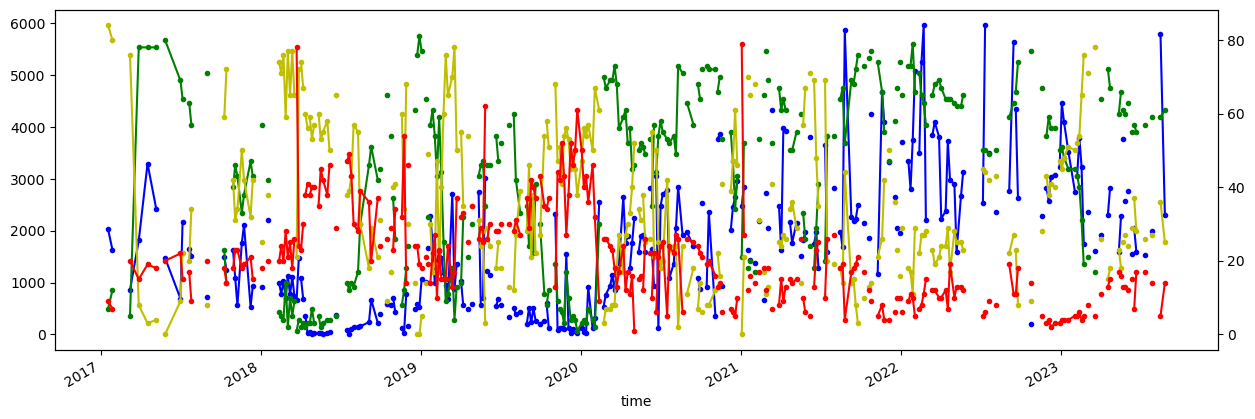

In [11]:
fig, ax=plt.subplots(figsize=[15,5])
ax2=ax.twinx()
this_pix['tsdm'].plot(ax=ax, c='b', marker='.')
this_pix['green'].plot(ax=ax2, c='g', marker='.')
this_pix['non-green'].plot(ax=ax2, c='y', marker='.')
this_pix['bare'].plot(ax=ax2, c='r', marker='.')
plt.show()

pick one date and show me the maps

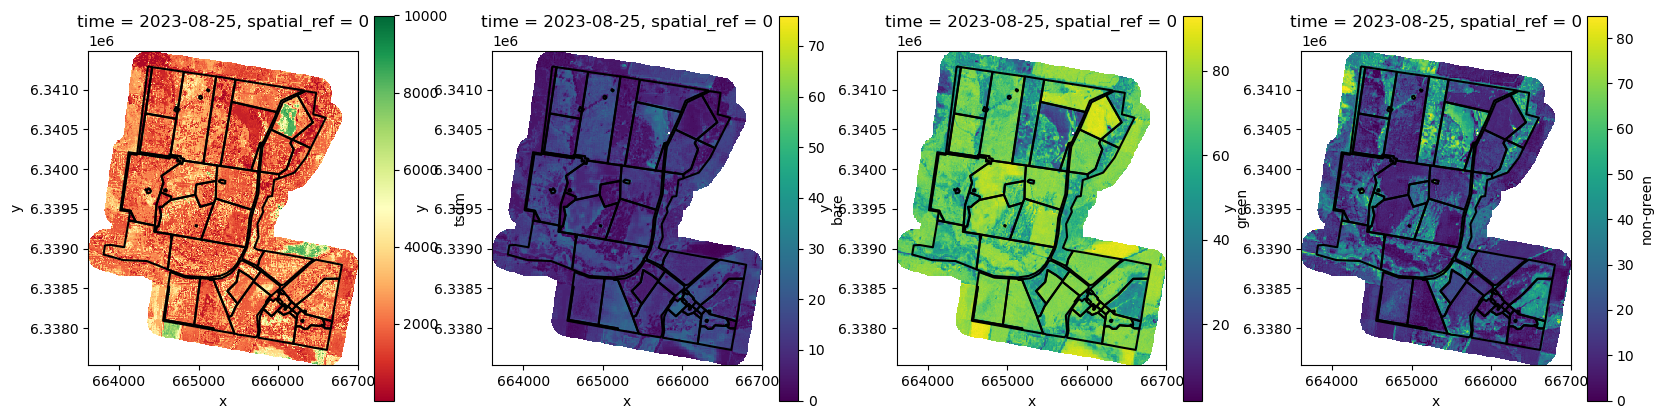

In [12]:
this_date= '2023-08-25'
 
fig, ax=plt.subplots(1,4, figsize=[20,5])

data['tsdm'].sel(time=this_date).plot(cmap='RdYlGn', ax=ax[0])
data['bare'].sel(time=this_date).plot(cmap='viridis', ax=ax[1])
data['green'].sel(time=this_date).plot(cmap='viridis', ax=ax[2])
data['non-green'].sel(time=this_date).plot(cmap='viridis', ax=ax[3])
for axes in ax:
    farm.to_crs(data.spatial_ref.crs_wkt).boundary.plot(color='k', ax=axes)
plt.show()


the data are quite noisy, I run a rolling median to smooth out the values

I had to write the function below as xarray rolling behaves different to what I need (like pandas rolling). It's very slow, I'd love to speed it up.

In [13]:
def rolling_median_time(ds, days=15, verbose=False, center=True, min_n=1):
    rolling_median=[]
    for this_date in ds['time'].to_pandas():
        if center:
            this_stack = ds.sel(time=slice(this_date-np.timedelta64(int(np.round(days/2)),'D'), this_date+np.timedelta64(int(np.round(days/2)),'D')))
        if not center:
            this_stack = ds.sel(time=slice(this_date-np.timedelta64(int(days),'D'), this_date))

        # if only one date, don't calculate anything
        if this_stack.time.shape[0] == 1:
            this_median = this_stack
            if verbose: print('one date', this_date)
            
        # if only two dates, do a mean (quicker than median)
        if this_stack.time.shape[0] == 2:
            this_median = this_stack.mean(dim='time')
            this_median = this_median.expand_dims(time=[this_date])
            if verbose: print('two dates', this_date)
            
        # if  3 or more dates, do a median (slow)
        if this_stack.time.shape[0] >= 3:
            this_median = this_stack.median(dim='time')
            this_median = this_median.expand_dims(time=[this_date])
            if verbose: print('three or more dates', this_date)

        # mask the results where min_n >= the number of obs
        if min_n>1:
            this_median_count = this_stack.count(dim='time')
            this_median = this_median.where(this_median_count >= min_n)
            
        rolling_median.append(this_median)
    
    rolling_median = xr.concat(rolling_median, dim='time')
    return rolling_median


In [132]:
# calculate a rolling median with a 25 day window, minimum of 3 valid points
data_rolling= rolling_median_time(data, days=25, verbose=True, center=True, min_n=3)
data_rolling

two dates 2017-01-18 00:00:00
two dates 2017-01-28 00:00:00
one date 2017-02-17 00:00:00
one date 2017-03-09 00:00:00
one date 2017-03-29 00:00:00
one date 2017-04-18 00:00:00
two dates 2017-05-08 00:00:00
two dates 2017-05-15 00:00:00
one date 2017-05-28 00:00:00
three or more dates 2017-07-02 00:00:00
three or more dates 2017-07-07 00:00:00
three or more dates 2017-07-09 00:00:00
three or more dates 2017-07-22 00:00:00
three or more dates 2017-07-27 00:00:00
three or more dates 2017-07-29 00:00:00
two dates 2017-08-11 00:00:00
two dates 2017-08-16 00:00:00
two dates 2017-08-31 00:00:00
two dates 2017-09-05 00:00:00
two dates 2017-10-02 00:00:00
three or more dates 2017-10-10 00:00:00
three or more dates 2017-10-15 00:00:00
three or more dates 2017-10-22 00:00:00
three or more dates 2017-10-30 00:00:00
three or more dates 2017-11-04 00:00:00
three or more dates 2017-11-09 00:00:00
three or more dates 2017-11-19 00:00:00
two dates 2017-11-24 00:00:00
two dates 2017-12-09 00:00:00
three

<xarray.Dataset>
Dimensions:      (time: 438, y: 396, x: 339)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-18 2017-01-28 ... 2023-08-30
  * x            (x) float64 6.636e+05 6.636e+05 6.636e+05 ... 6.67e+05 6.67e+05
  * y            (y) float64 6.341e+06 6.341e+06 ... 6.338e+06 6.338e+06
    spatial_ref  int32 0
Data variables:
    tsdm         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    bare         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    non-green    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

compare the result for the same pixel as before:
                  

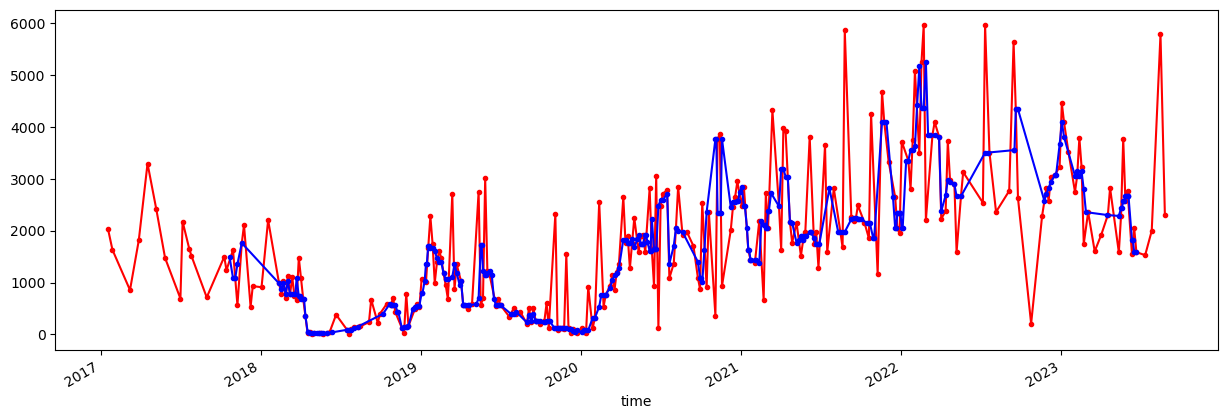

In [133]:
fig, ax=plt.subplots(figsize=[15,5])

data.isel(x=x, y=y).to_dataframe()['tsdm'].dropna().plot(ax=ax, c='r', marker='.')
data_rolling.isel(x=x, y=y).to_dataframe()['tsdm'].dropna().plot(ax=ax, c='b', marker='.')
plt.show()

## now comes the beauty of xarrays
calculate a mean for each month for tsdm and plot (the plot is in the file `fc_by_year_month.png`)

In [188]:
data_monthly = data_rolling.resample(time="M").mean(dim="time")
data_monthly

<xarray.Dataset>
Dimensions:      (x: 339, y: 396, time: 80)
Coordinates:
  * x            (x) float64 6.636e+05 6.636e+05 6.636e+05 ... 6.67e+05 6.67e+05
  * y            (y) float64 6.341e+06 6.341e+06 ... 6.338e+06 6.338e+06
  * time         (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-08-31
    spatial_ref  int32 0
Data variables:
    tsdm         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    bare         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    non-green    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [189]:
data_monthly['year'] = (data_monthly.time.dt.year)
data_monthly['month'] = (data_monthly.time.dt.month)
data_monthly = data_monthly.set_index(time=['year','month']).unstack('time')
aspect = data_monthly.x.shape[0] / data_monthly.y.shape[0] 

p= (data_monthly[['bare','green','non-green']].
    to_array().
    plot.
    imshow(
        col='year',
         row='month',
         vmin=0,
         vmax=100,
         aspect=aspect,
         size=2)
   )

"""
c=0
for ax0 in p.axes.flatten():
    buff.boundary.plot(edgecolor='k', linewidth=0.5, ax=ax0)
    flight.boundary.plot(edgecolor='k', linewidth=0.5, ax=ax0)
    ax0.yaxis.set_ticklabels([])
    ax0.xaxis.set_ticklabels([])
    c=c+1
"""
 
#for ax in p.axes.flatten():
#    farm.to_crs(data_monthly.spatial_ref.crs_wkt).boundary.plot(edgecolor='k', linewidth=0.5, ax=ax)
p.fig.savefig('fc_by_year_month.png')
plt.close()

C:\Users\Juan\anaconda3\envs\base-rs-new\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


for understanding the colors above, see this fig  https://support.cibolabs.com.au/hs-fs/hubfs/FractionalCover-jpg.jpeg

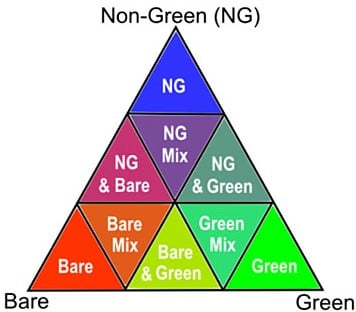

In [161]:
from IPython import display
display.Image("https://support.cibolabs.com.au/hs-fs/hubfs/FractionalCover-jpg.jpeg")

similar thing for tsdm, see the image in `tsdm_by_year_month.png`

In [193]:
p= (
    data_monthly['tsdm'].    
    plot.
    imshow(
        col='year',
        row='month',
        vmin=0,
        vmax=6000,
        cmap='RdYlGn',
        aspect=aspect,
        size=2)
   )

"""
c=0
for ax0 in p.axes.flatten():
    buff.boundary.plot(edgecolor='k', linewidth=0.5, ax=ax0)
    flight.boundary.plot(edgecolor='k', linewidth=0.5, ax=ax0)
    ax0.yaxis.set_ticklabels([])
    ax0.xaxis.set_ticklabels([])
    c=c+1
"""
 
#for ax in p.axes.flatten():
#    farm.to_crs(data_monthly.spatial_ref.crs_wkt).boundary.plot(edgecolor='k', linewidth=0.5, ax=ax)
p.fig.savefig('tsdm_by_year_month.png')
plt.close()

## example statistics across space and across time
this is the TSDM  mean for the whole farm over time

this is similar to what snowflake has for each paddock

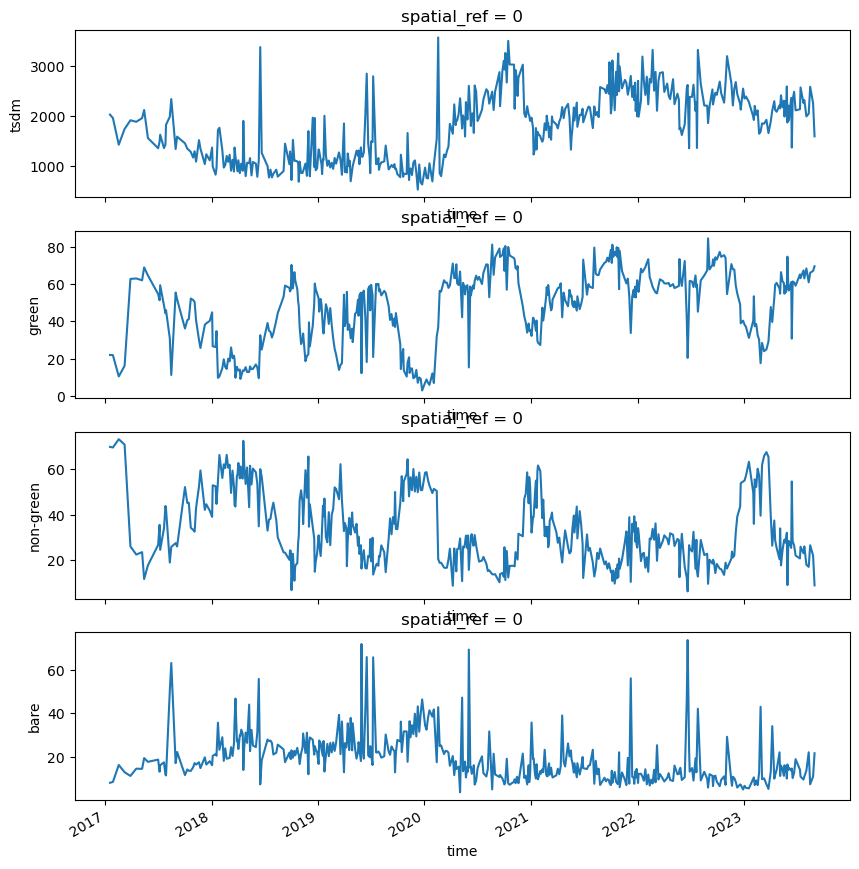

In [22]:
fig, ax= plt.subplots(4, figsize=[10,10], sharex=True)
data['tsdm'].mean(dim=['x','y']).plot(ax=ax[0])
data['green'].mean(dim=['x','y']).plot(ax=ax[1])
data['non-green'].mean(dim=['x','y']).plot(ax=ax[2])
data['bare'].mean(dim=['x','y']).plot(ax=ax[3])

plt.show()

and this is the mean for each pixel over time. The result has to be shown as a map

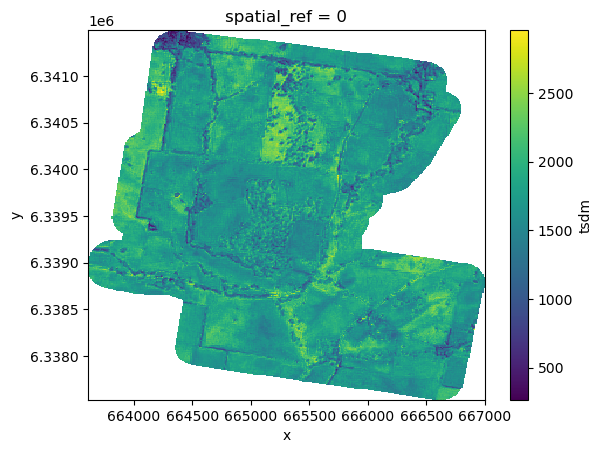

In [187]:
data['tsdm'].mean(dim=['time']).plot()

these are the quantiles over time for each band. This is the same as what's on the files 
 
```
'/vsis3/cibo-agriwebb/tiles/agriwebb_summary_band1.tif',
'/vsis3/cibo-agriwebb/tiles/agriwebb_summary_band2.tif',
'/vsis3/cibo-agriwebb/tiles/agriwebb_summary_band3.tif',
'/vsis3/cibo-agriwebb/tiles/agriwebb_summary_tsdm.tif',
```


In [184]:
quantiles = data.quantile(q=[0.1,0.25,0.5,0.75,0.9], dim='time')
quantiles

C:\Users\Juan\anaconda3\envs\base-rs-new\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.Dataset>
Dimensions:    (quantile: 5, y: 396, x: 339)
Coordinates:
  * x          (x) float64 6.636e+05 6.636e+05 6.636e+05 ... 6.67e+05 6.67e+05
  * y          (y) float64 6.341e+06 6.341e+06 6.341e+06 ... 6.338e+06 6.338e+06
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    tsdm       (quantile, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    bare       (quantile, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green      (quantile, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    non-green  (quantile, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [177]:
# show them in a a plot

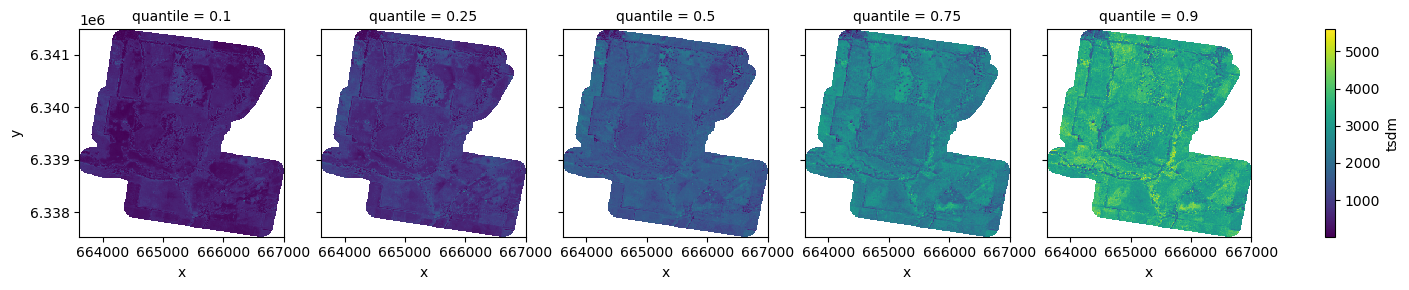

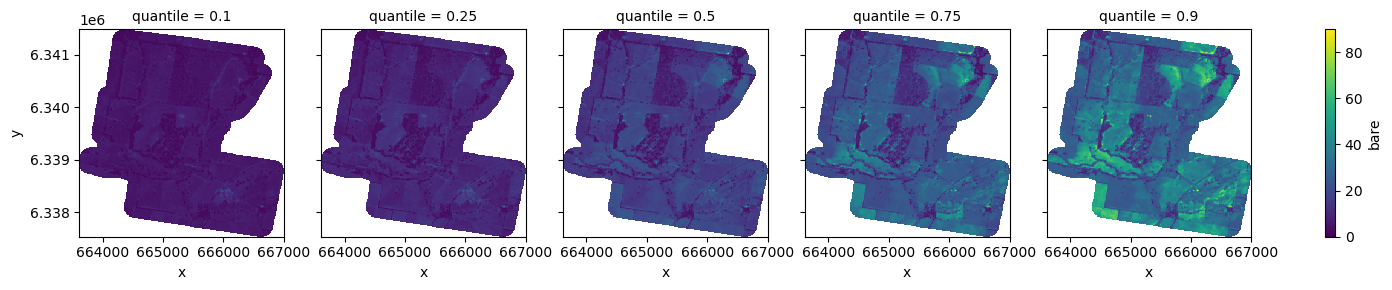

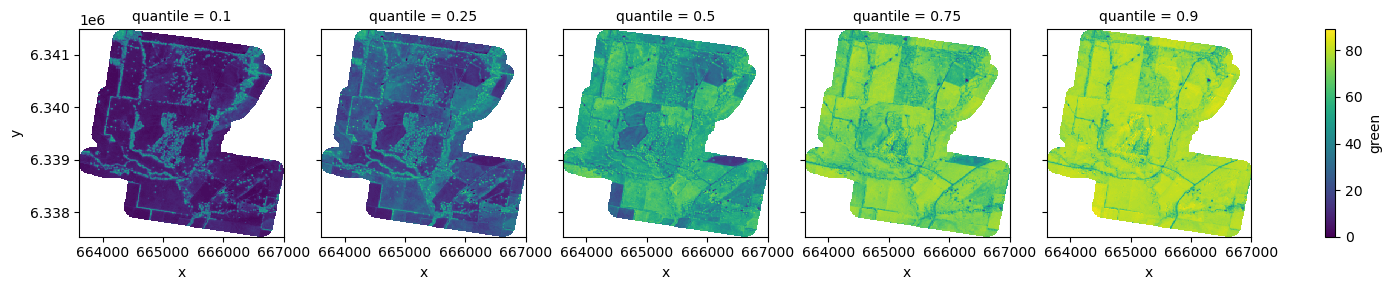

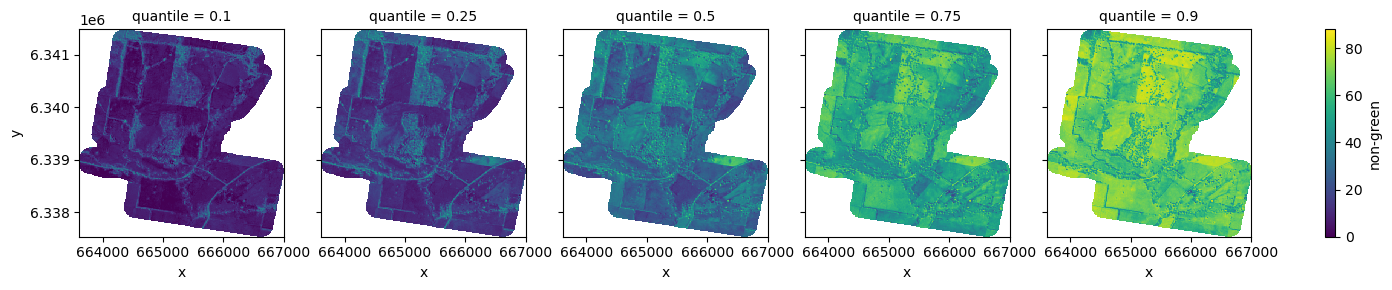

In [186]:
for data_var in quantiles.data_vars: 
    quantiles[data_var].plot.imshow(col='quantile')